# Рассчет профилей спектральных линий в приближении Милна-Эддингтона

Описание модуля MeModel, основной функции и базовых классов

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import sys

In [2]:
#TODO :: colab version

IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [3]:
sys.path.append('..')
from astropy.io import fits
from inverse_problem.milne_edington.me import HinodeME, BatchHinodeME
from inverse_problem import me_model

## Блок me_model
### Входные параметры функции

- line_vec - вектор параметров линии (постоянны при решении обратной задачи):
    + wl0 - центральная длина волны линии (в ангстремах), 
    + g - Ланде-фактор линии
    + mu - косинус угла между LOS и нормалью поверхности 
- param_vec - вектор параметров инверсии (подбираются при решении обратной задачи):

        +(0) B - величина магнитного поля (в гауссах)
        +(1) theta - угол наклона магнитного поля (в радианах)
        +(2) xi - азимут магнитного поля (в радианах)
        +(3) D - доплеровское уширение линии (в миллиангстремах)
        +(4) gamma - лоренцовское затухание линии (в миллиангстремах)
        +(5) Line Strength (интенсивность) 
        +(6) Функция источника
        +(7) Градиент функции источника
        +(8) Dop_shift - доплеровский сдвиг линии (в миллиангстремах)
        +(9) Фактор заполнения
        +(10) Доплеровский сдвиг для немагнитной части
    
- line_arg - точки рассчета параметров IQUV (в миллиангстремах от центральной длины волны)

### Выход функции:
    спектральные линии в формате (n, len(line_arg), 4)
    То есть мы получаем для заданного вектора параметров инверсии вектор Стокса IQUV в точках определенных line_arg.
    

### Построение модельной спектрограммы

Тут хотим посмотреть поведение функций при разных входных параметрах? Внизу вид при нулевом поле, почему это интересно?
А что интересно еще? Можно побольше разных комбинаций

In [4]:
def plot_lines(param_vec, line_vec = None, line_arg = None, with_noise = True, with_ff = True):
    """
    Help function for plot results of me_model reconstruction from parameters
    """
    if line_vec is None:
        line_vec = (6302.5, 2.5, 1)
    if line_arg is None:
         line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56) - line_vec[0])

    if with_ff:
        print('Compute ME with filling factor')
        lines = me_model(param_vec, line_arg, line_vec, with_ff=with_ff, with_noise=with_noise, norm = False)
    else:
        print('Compute ME without filling factor')
        lines = me_model(param_vec, line_arg, line_vec, with_ff=with_ff, with_noise=with_noise, norm = False)

    line_type = ['I','Q','U','V']

    fig, ax = plt.subplots(2,2, figsize = (10,5))
    for i in range(4):
        ax[i//2][i%2].plot(line_arg, lines[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.set_tight_layout(tight = True)
    fig.suptitle(f'Used parameters B:{param_vec[0]}, theta:{param_vec[1]}, azimut:{param_vec[2]}, D:{param_vec[3]}, gamma:{param_vec[4]}, intesity: {param_vec[5]}, shift:{param_vec[8]}')
    return lines
    

###  Интересные варианты сочетаний параметров

Compute ME without filling factor


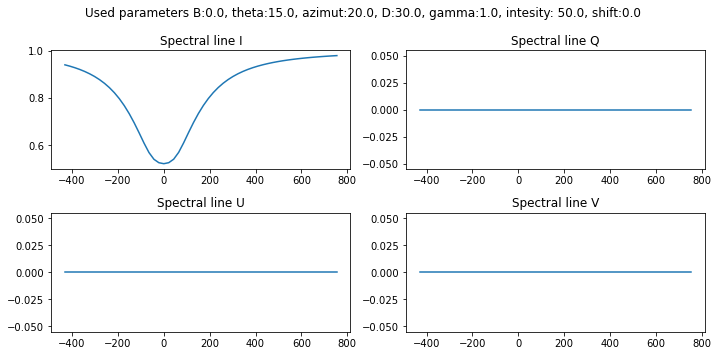

In [7]:
param_vec = [0., 15., 20., 30., 1., 50., 0.5, 0.5, 0., 1., 0.]

_ = plot_lines(param_vec, with_ff=False, with_noise = False)

Магнитного поля нет - ненулевая только компонента I

Compute ME without filling factor


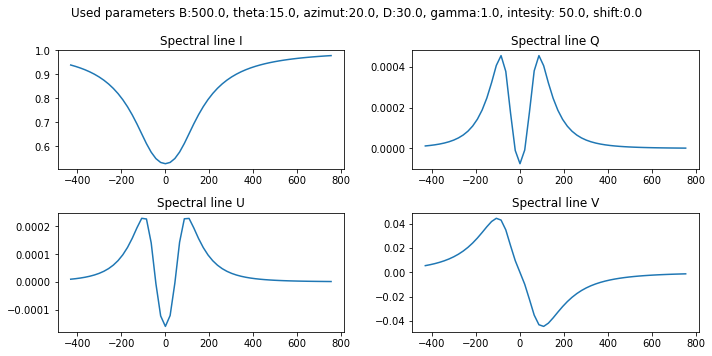

In [8]:
param_vec = [500., 15., 20., 30., 1., 50., 0.5, 0.5, 0., 1., 0.]
_ = plot_lines(param_vec, with_ff=False, with_noise = False)

### Функция с коэффициентом заполнения



Функция  аналогична предыдущей, но с введением двух дополнительных параметров инверсии - коэффициента заполнения элемента магнитным полем (filling factor) и доплеровского сдвига для немагнитной части элемента

Compute ME with filling factor


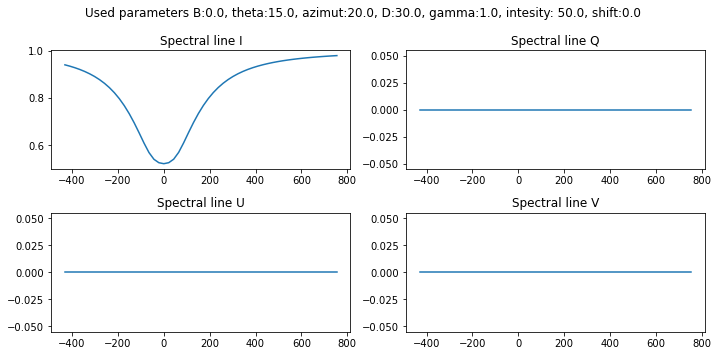

In [9]:
param_vec = [0., 15., 20., 30., 1., 50., 0.5, 0.5, 0., 0, 0.]

_ = plot_lines(param_vec, with_ff=True, with_noise = False)

Коэффициент заполнения = 1, профили полностью соответствуют примеру выше

Compute ME with filling factor


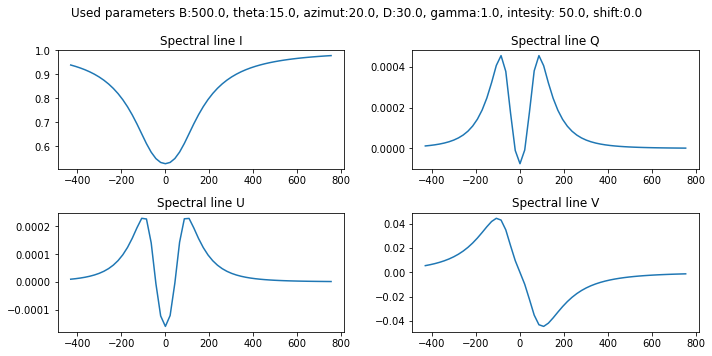

In [10]:
param_vec = [500., 15., 20., 30., 1., 50., 0.5, 0.5, 0., 1., 0.]
_ = plot_lines(param_vec, with_ff=True, with_noise = False)

### Генерация спектра для массива параметров


In [11]:
param_array = fits.open('../data/small_parameters_base.fits')[0].data

In [12]:
line_vec = (6302.5, 2.5, 1)
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56) - line_vec[0])
lines = me_model(param_array, line_arg, line_vec, with_ff=True, with_noise=True, norm=True)
print(lines.shape)

(1000, 56, 4)


### Нормировка интенсивности


#### TODO 
- надо переделать под источники
Параметр 7 в векторе p_v - интенсивность. Он определяет величину профиля и при генерации просто домножается в конце на посчитанный профиль единичной амплитуды. В реальных измерениях интенсивность значительно меняется и является одним из параметров инверсии. Для hinode она лежит в интервале около [4000 : 20000]

Compute ME without filling factor


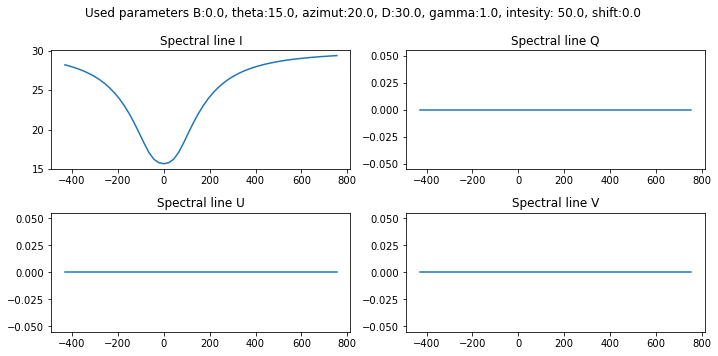

In [13]:
param_vec = [0., 15., 20., 30., 1., 50., 15, 15, 0., 1., 0.]

_ = plot_lines(param_vec, with_ff=False, with_noise = False)

In [16]:
p_v0 = [500., 15., 20., 30., 1., 50., 150, 150, 0., 1., 0.]
p_v1 = [500., 15., 20., 30., 1., 50., 0.5, 0.5, 0., 1., 0.]
lines0 = me_model(p_v0, line_arg, line_vec, with_ff=True, with_noise=False, norm=False)
lines1 = me_model(p_v1, line_arg, line_vec, with_ff=True, with_noise=False, norm=False)

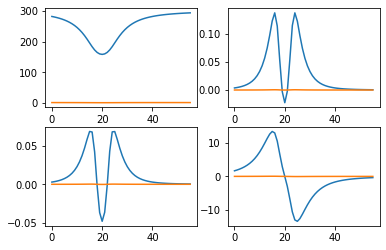

In [17]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(lines0[0,:,i])
    plt.plot(lines1[0,:,i])

In [18]:
lines0 = lines0 / lines0[0][0]
lines1 = lines1 / lines1[0][0]

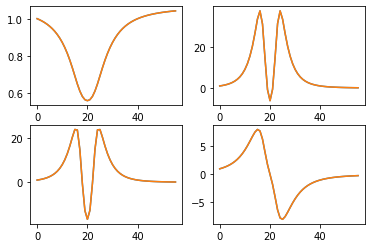

In [20]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(lines0[0,:,i])
    plt.plot(lines1[0,:,i])

(Спектры совпали, т.к. остальные параметры равны)
Таким образом, можно значительно снизить искомый диапазон по величине интенсивности, оставив небольшой интервал около 1.

## Классы HinodeMe, BatchHinodeME

Используются дальше для построения сетей
Инициализованы параметры спектральных линий и добавлена возможность загружать параметры из рефереров

HinodeME: умеет только работать с вектором параметров

In [84]:
param_array[0]

array([  120.75728607,    86.54639435,   121.17935944,    27.93532944,
           0.16206644,    19.25868607, 27237.19140625, 16279.05078125,
           0.62147099,     0.43586645,     0.23069054])

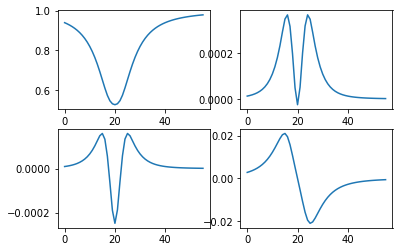

In [85]:
param_vec = [1000., 15., 20., 30., 1., 50., 0.5, 0.5, 0., 0.25, 0.]
obj = HinodeME(param_vec)
spectrum = obj.compute_spectrum(with_ff=True, with_noise=False)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(np.array(spectrum[0,:,i]))

!!  Вот тут у нас не косяк?

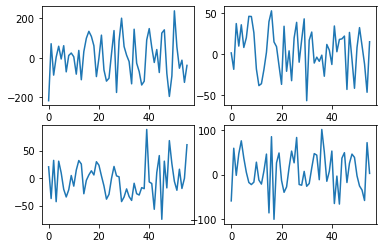

In [87]:
param_vec = [1000., 15., 20., 30., 1., 50., 0.5, 0.5, 0., 0.25, 0.]
obj = HinodeME(param_vec)
spectrum = obj.compute_spectrum(with_ff=True, with_noise=True)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(np.array(spectrum[0,:,i]))

In [92]:
#  успокаивает что вроде в реальной жизни так быть не может, но вообще че-то мне не очень нравится

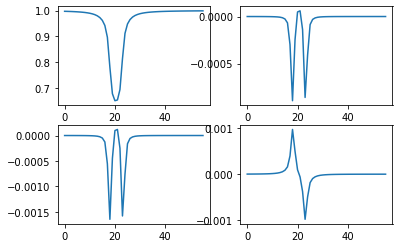

In [93]:
obj = HinodeME(param_array[0])
spectrum = obj.compute_spectrum(with_ff=True, with_noise=False)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(np.array(spectrum[0,:,i]))

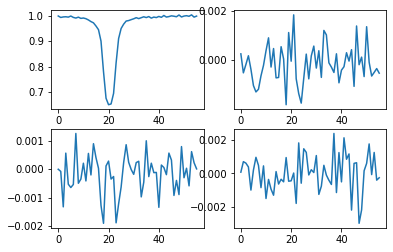

In [94]:
obj = HinodeME(param_array[0])
spectrum = obj.compute_spectrum(with_ff=True, with_noise=True)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(np.array(spectrum[0,:,i]))

In [96]:
# можно читать прямо из базы параметров, указывая индекс
obj = HinodeME.from_parameters_base(2, param_array)
spectrum = obj.compute_spectrum(with_ff=True, with_noise=False)
spectrum_noised = obj.compute_spectrum(with_ff=True, with_noise=True)

### BatchHinodeME
генерация спектров сразу для базы данных или для всего реферера

In [99]:
obj = BatchHinodeME(param_array)
spectrum = obj.compute_spectrum(with_ff=True, with_noise=True)
print(spectrum.shape)

(1000, 56, 4)
